In [6]:
import numpy as np
import cv2
from PIL import Image
import os
import skimage as ski
import matplotlib.pyplot as plt
import pywt
from skimage import io, restoration, img_as_float
from natsort import natsorted, ns
from inference import get_model
from inference_sdk import InferenceHTTPClient
from inference.models.utils import get_roboflow_model
from ultralytics import YOLO, settings

Load training images from dataset.

In [2]:
def load_images(folder):
    images = []
    try:
        for filename in os.listdir(folder):
            img_path = os.path.join(folder, filename)
            try:
                img = Image.open(img_path)
                images.append(img)
            except IOError as e:
                print(f"Could not open image {img_path}: {e}")
    except PermissionError as e:
        print(f"Permission denied: {e}")
    return images

image_path = "C:/Users/needh/OneDrive/Documents/Uni/2024/Sem 2 2024/ICT342/SEAING/Training Images/Underwater Marine Species.v6-marinedataset_v5.yolov8/train/images"

images = load_images(image_path)

Apply image enhancements.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.009624910019396343..1.0057033413919458].


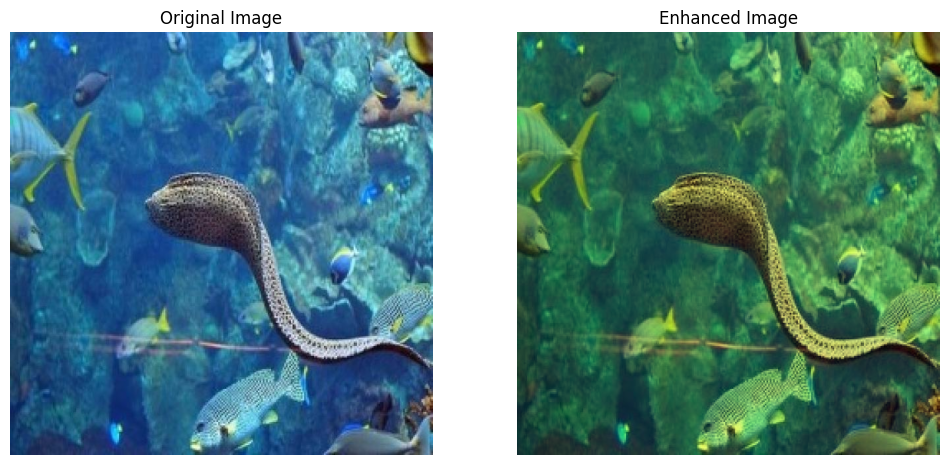

In [7]:
# Enhancements only applied on one image for testing purposes atm and doesn't use the code above.

image = io.imread('C:/Users/needh/OneDrive/Documents/Uni/2024/Sem 2 2024/ICT342/SEAING/Training Images/Underwater Marine Species.v6-marinedataset_v5.yolov8/train/images/0HM9KWRRG6FN_jpg.rf.58681507bb0c920c258c1699ec9a6175.jpg')
image = img_as_float(image)

# Denoise image
denoised_image = restoration.denoise_wavelet(image)

# Step 2: Reduce blue color
# Split the image into R, G, B channels
r, g, b = denoised_image[:, :, 0], denoised_image[:, :, 1], denoised_image[:, :, 2]

# Reduce the blue channel intensity
b = b * 0.5  # Adjust the factor as needed

# Merge the channels back
enhanced_image = np.stack((r, g, b), axis=-1)

# Display the original and enhanced images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(enhanced_image)
ax[1].set_title('Enhanced Image')
ax[1].axis('off')

plt.show()

Load labels from dataset.

In [ ]:
def load_labels(folder):
    labels = {}
    try:
        for filename in os.listdir(folder):
            if filename.endswith(".txt"):
                label_path = os.path.join(folder, filename)
                with open(label_path, 'r') as file:
                    label_data = file.readlines()
                    labels[filename] = [line.strip() for line in label_data]
    except PermissionError as e:
        print(f"Permission denied: {e}")
    return labels

label_path = "C:/Users/needh/OneDrive/Documents/Uni/2024/Sem 2 2024/ICT342/SEAING/Training Images/Underwater Marine Species.v6-marinedataset_v5.yolov8/train/labels"
labels = load_labels(label_path)
print(labels)

Setup/Check Ultralytics and set correct directory path.

In [ ]:
print(settings)

value = settings["runs_dir"]
settings.update({"datasets_dir": "C:/Users/needh/OneDrive/Documents/Uni/2024/Sem 2 2024/ICT342/SEAING/Training Images/Underwater Marine Species.v6-marinedataset_v5.yolov8"})

Import Roboflow pre-trained dataset "Underwater Marine Species Computer Vision Project"

In [ ]:
# Add your own image path to any arbitrary image. It currently only loads one image so we need to figure out how to load all images.
image_path = "C:/Users/needh/OneDrive/Documents/Uni/2024/Sem 2 2024/ICT342/SEAING/Training Images/Underwater Marine Species.v6-marinedataset_v5.yolov8/train/images/288856187_d1fb57a113_b_jpg.rf.1a861f6bf38998d756e6f76a84b73340.jpg"

# Roboflow model
model_name = "underwater-marine-species"
model_version = "6"

# Get Roboflow face model (this will fetch the model from Roboflow)
model = get_roboflow_model(
    model_id="{}/{}".format(model_name, model_version),

    #Replace ROBOFLOW_API_KEY with your Roboflow API Key
    api_key="J7ljP04frhJRcBuovOmD"
)

In [6]:
frame = cv2.imread(image_path)

results = model.infer(image=frame,
                        confidence=0.5,
                        iou_threshold=0.5)

In [ ]:
if results[0].predictions:
    prediction = results[0].predictions[0]
    print(prediction)
    
    x_center = int(prediction.x)
    y_center = int(prediction.y)
    width = int(prediction.width)
    height = int(prediction.height)

    # Calculate top-left and bottom-right corners from center, width, and height
    x0 = x_center - width // 2
    y0 = y_center - height // 2
    x1 = x_center + width // 2
    y1 = y_center + height // 2
    
    # Currently only takes one input text as a label
    cv2.rectangle(frame, (x0, y0), (x1, y1), (255,255,0), 10)
    cv2.putText(frame, "fish", (x0, y0 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2)

Display chosen image.

In [8]:
# Show the image from image path. When we get multiple/all images to be loaded we don't want them all to be rendered simultaneously, so this will need to be modified.
cv2.imshow('Image Frame', frame)
cv2.waitKey(0) # waits until a key is pressed
cv2.destroyAllWindows() # destroys the window showing image